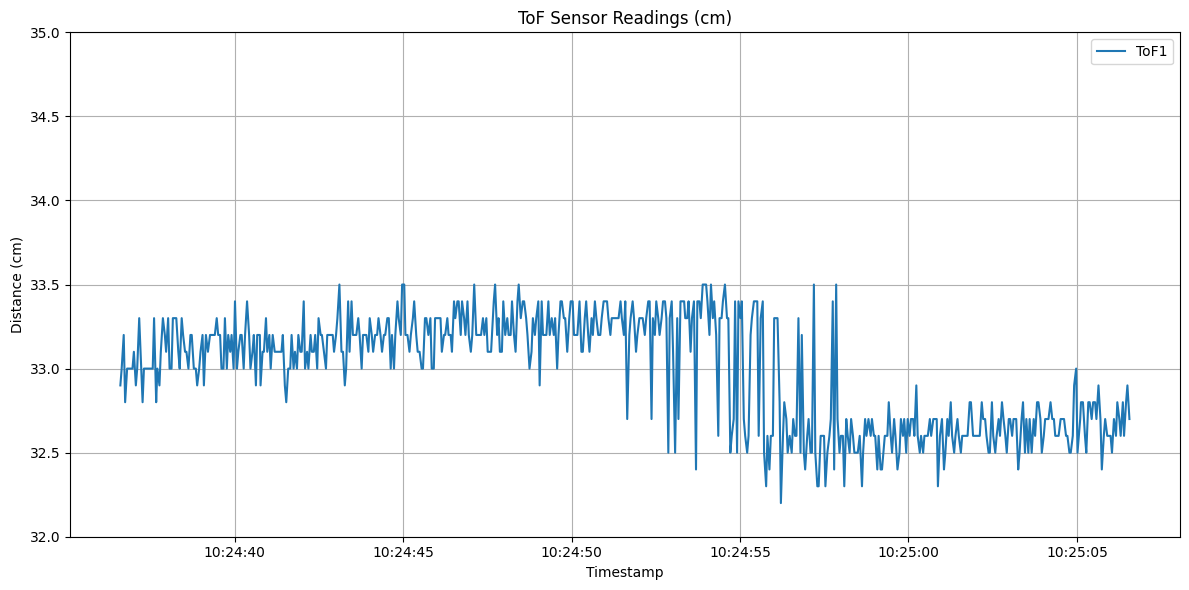

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv("../data/abnormal_tof_30.csv")

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Convert ToF values from mm to cm
for col in ['tof1']:
    df[col] = df[col] / 10.0

# Plot ToF1 (in cm) with the specified y-axis range
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['tof1'], label='ToF1')
plt.xlabel('Timestamp')
plt.ylabel('Distance (cm)')
plt.title('ToF Sensor Readings (cm)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim(32, 35) # Set y-axis from 20 to 40 cm
plt.show()

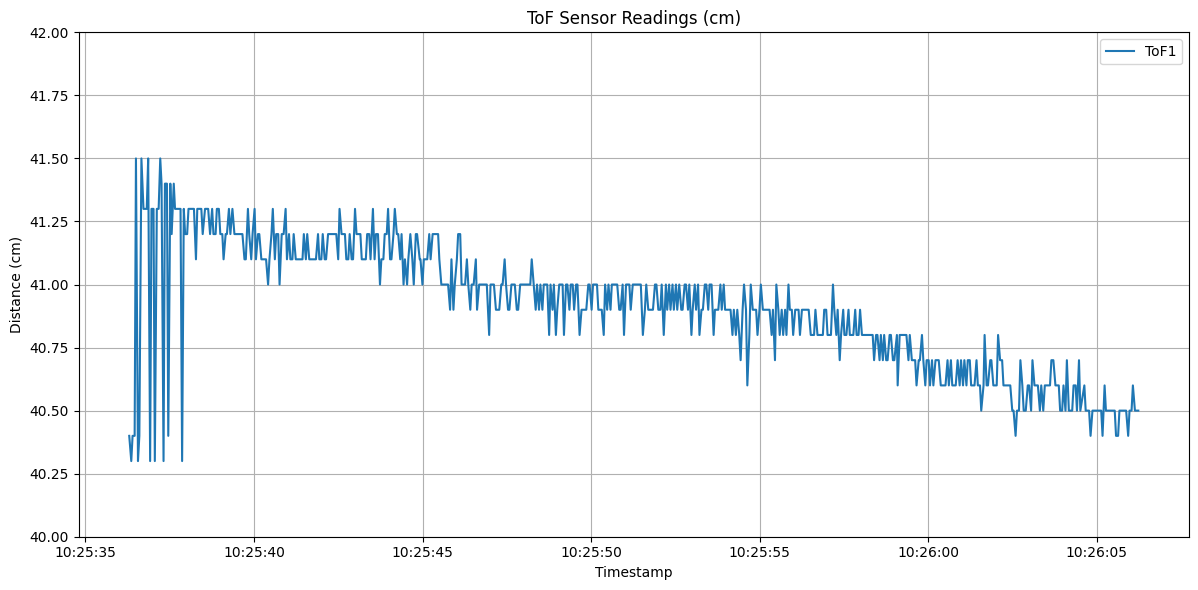

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# อ่านไฟล์ CSV
df = pd.read_csv("../data/abnormal_tof_40.csv")

# แปลง timestamp เป็น datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# แปลงค่า ToF จาก mm เป็น cm
for col in ['tof1']:
    df[col] = df[col] / 10.0

# Plot กราฟ ToF ทั้ง 4 ตัว (หน่วย cm)
plt.figure(figsize=(12,6))
plt.plot(df['timestamp'], df['tof1'], label='ToF1')
plt.xlabel('Timestamp')
plt.ylabel('Distance (cm)')
plt.title('ToF Sensor Readings (cm)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim(40, 42)
plt.show()

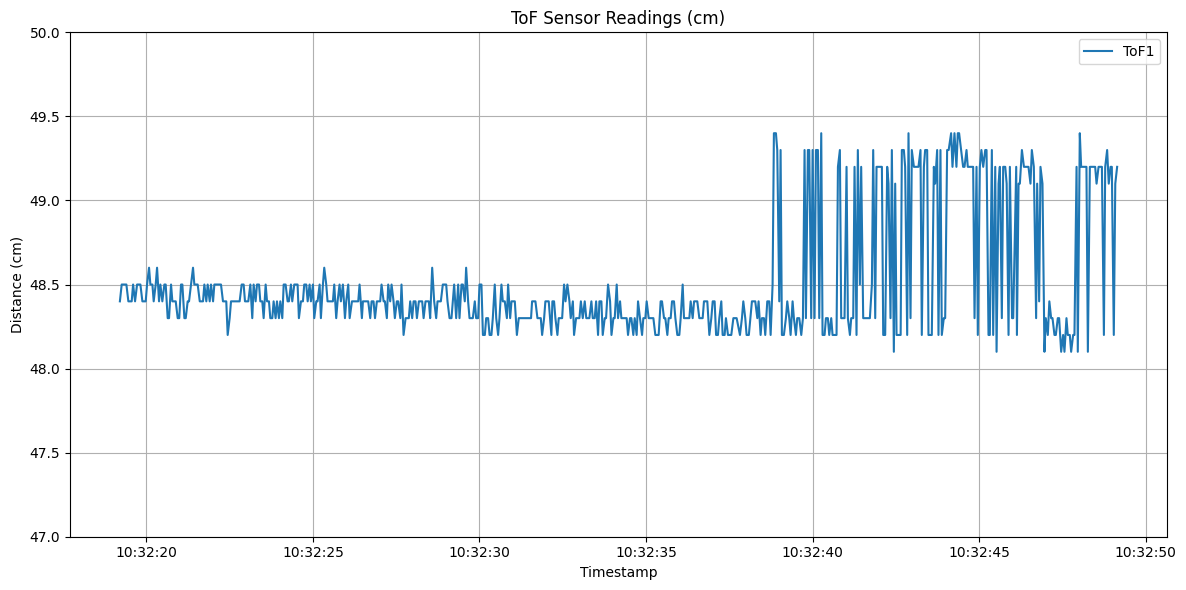

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# อ่านไฟล์ CSV
df = pd.read_csv("../data/abnormal_tof_50.csv")

# แปลง timestamp เป็น datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# แปลงค่า ToF จาก mm เป็น cm
for col in ['tof1']:
    df[col] = df[col] / 10.0

# Plot กราฟ ToF ทั้ง 4 ตัว (หน่วย cm)
plt.figure(figsize=(12,6))
plt.plot(df['timestamp'], df['tof1'], label='ToF1')
plt.xlabel('Timestamp')
plt.ylabel('Distance (cm)')
plt.title('ToF Sensor Readings (cm)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim(47, 50)
plt.show()

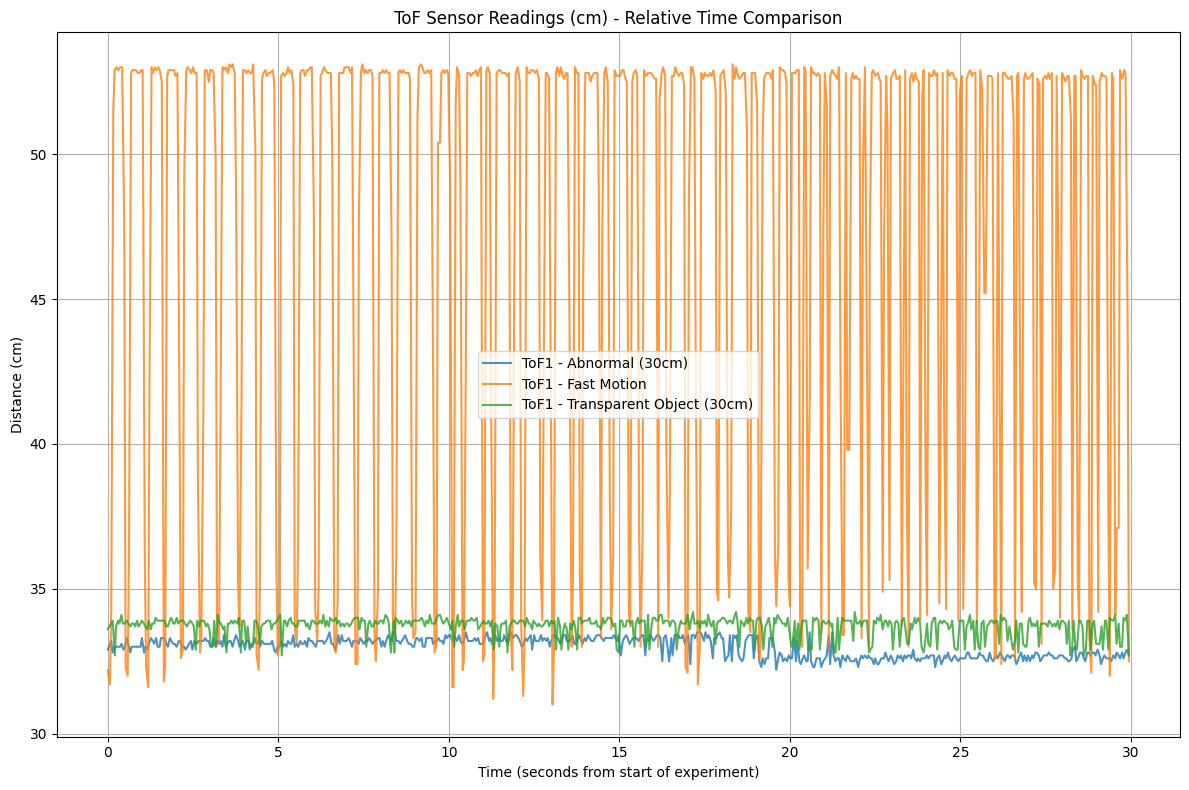

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Define file names and their corresponding labels for the plot
file_names = {
    "../data/abnormal_tof_30.csv": "Abnormal (30cm)",
    "../data/fast_motion_tof.csv": "Fast Motion",
    "../data/transparent_tof_30.csv": "Transparent Object (30cm)"
}

all_data = []

for file_name, label in file_names.items():
    try:
        df = pd.read_csv(file_name)

        # Convert 'timestamp' column to datetime objects
        # 'errors='coerce'' will turn invalid parsing into NaT (Not a Time)
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
        # Drop rows where timestamp conversion failed
        df.dropna(subset=['timestamp'], inplace=True)

        if not df.empty:
            # Calculate Relative Time: Set the start time of each experiment to 0 seconds
            df['relative_time'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()
            
            # Convert tof1 from millimeters (mm) to centimeters (cm)
            # Assuming tof1 values in the CSV are originally in millimeters.
            # If they are already in cm, you can remove this line.
            df['tof1_cm'] = df['tof1'] / 10.0 
            
            df['Experiment'] = label
            # Select relevant columns: relative_time, converted tof1_cm, and Experiment label
            df_selected = df[['relative_time', 'tof1_cm', 'Experiment']].copy()
            all_data.append(df_selected)
        else:
            print(f"File {file_name} is empty or has no valid timestamps after processing.")

    except FileNotFoundError:
        print(f"File not found: {file_name}")
    except KeyError as e:
        print(f"Missing expected column in {file_name}: {e}")
    except Exception as e:
        print(f"An error occurred while processing {file_name}: {e}")

if not all_data:
    print("No data loaded. Cannot create plot.")
else:
    # Concatenate all processed DataFrames into a single DataFrame
    combined_df = pd.concat(all_data)

    # Create the plot
    plt.figure(figsize=(12, 8))

    # Plot each experiment's data separately to ensure distinct legends
    for label in combined_df['Experiment'].unique():
        subset = combined_df[combined_df['Experiment'] == label]
        # Plotting 'tof1_cm' (converted to centimeters)
        plt.plot(subset['relative_time'], subset['tof1_cm'], label=f'ToF1 - {label}', alpha=0.8) 

    plt.title('ToF Sensor Readings (cm) - Relative Time Comparison')
    plt.xlabel('Time (seconds from start of experiment)')
    plt.ylabel('Distance (cm)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout() # Adjust plot layout to prevent labels from overlapping
    plt.show()

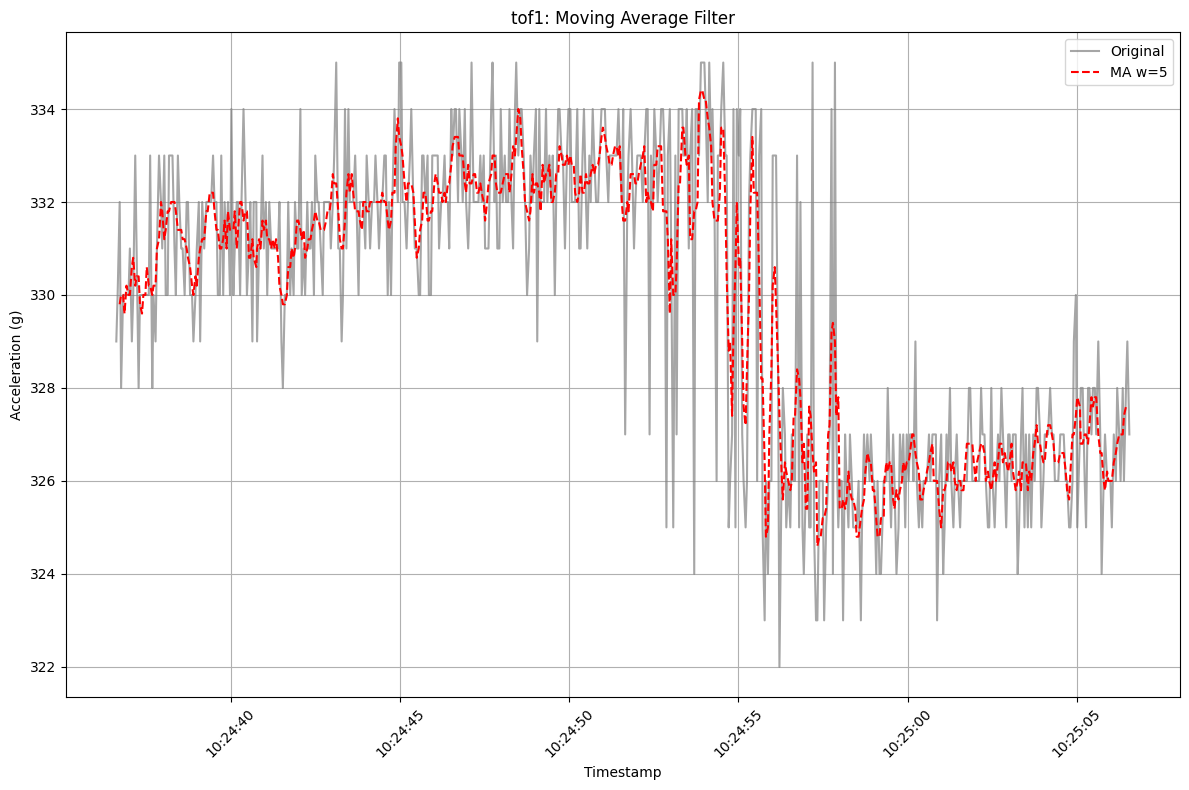

In [8]:
# MOving Average Filter

import pandas as pd
import matplotlib.pyplot as plt

# อ่านไฟล์ CSV
df = pd.read_csv("../data/abnormal_tof_30.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])

acc_cols = ['tof1']
df_filtered = df.copy()

# Moving Average Filter
for col in acc_cols:
    df_filtered[f'{col}_MA_w5'] = df[col].rolling(window=5, center=True).mean()
    


# สร้างกราฟแยกทีละแกน
plt.figure(figsize=(12, 8))


plt.plot(df['timestamp'], df[col], label='Original', color='gray', alpha=0.7)
plt.plot(df_filtered['timestamp'], df_filtered[f'{col}_MA_w5'], label='MA w=5', linestyle='--', color='red')
plt.title(f'{col}: Moving Average Filter')
plt.xlabel('Timestamp')
plt.ylabel('Acceleration (g)')
plt.legend()
plt.grid(True)
plt.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Calculated Sampling Rate: 19.67 Hz


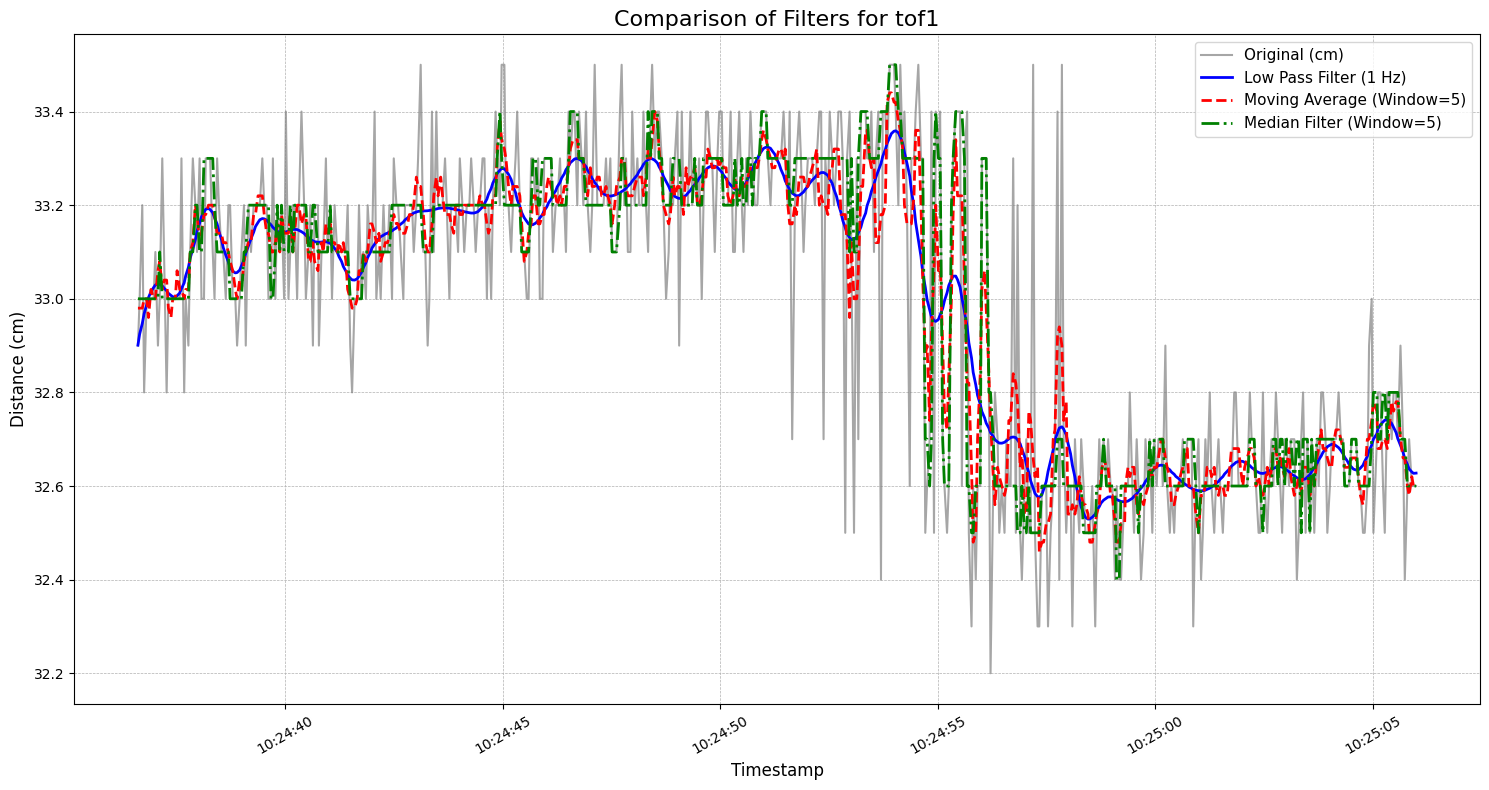

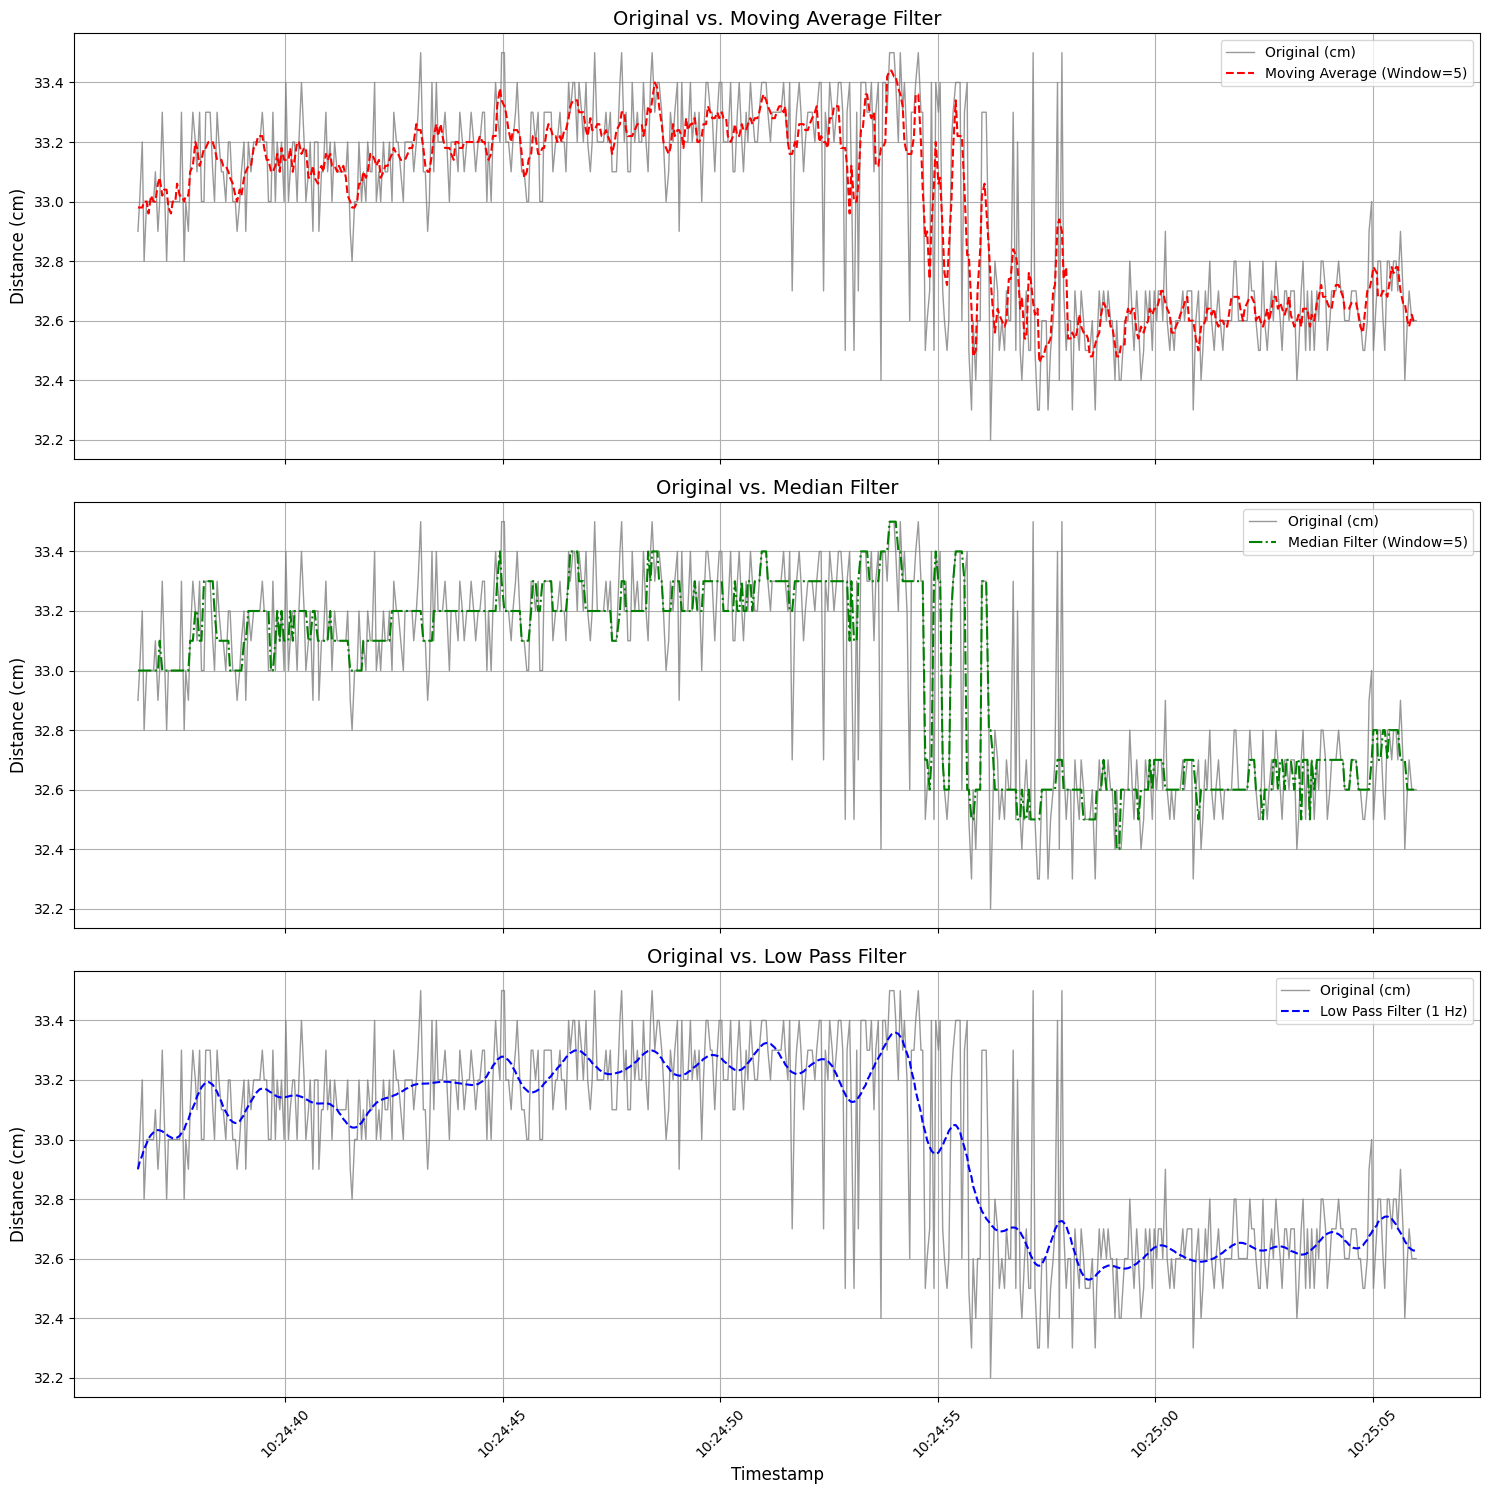

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import numpy as np

# --- อ่านไฟล์ CSV ---
# หมายเหตุ: โปรดตรวจสอบให้แน่ใจว่า path ไปยังไฟล์ 'abnormal_tof_30.csv' ถูกต้อง
# หากรันในสภาพแวดล้อมที่ไม่มีไฟล์ จะมีการสร้างข้อมูลจำลองขึ้นมาแทน
try:
    df = pd.read_csv("../data/abnormal_tof_30.csv")
except FileNotFoundError:
    print("ไม่พบไฟล์ 'abnormal_tof_30.csv' จึงสร้างข้อมูลจำลองขึ้นเพื่อทดสอบ")
    timestamps = pd.to_datetime(pd.date_range(start='2025-07-23 10:24:00', end='2025-07-23 10:26:00', freq='100ms'))
    base_signal = 150 + 5 * np.sin(np.linspace(0, 10, len(timestamps)))
    noise = np.random.normal(0, 5, len(timestamps))
    spikes = np.zeros(len(timestamps))
    spike_indices = np.random.choice(len(timestamps), 20, replace=False)
    spikes[spike_indices] = np.random.choice([-50, 50], 20)
    tof1_data = base_signal + noise + spikes
    df = pd.DataFrame({'timestamp': timestamps, 'tof1': tof1_data})

df['timestamp'] = pd.to_datetime(df['timestamp'])

# --- กำหนดค่าเริ่มต้น ---
tof_col = 'tof1'
conversion_factor = 0.1  # 1 mm = 0.1 cm
df_filtered = df.copy()

# แปลงข้อมูลต้นฉบับเป็นหน่วยเซนติเมตร
df_filtered[f'{tof_col}_cm'] = df_filtered[tof_col] * conversion_factor

# --- คำนวณอัตราการสุ่มตัวอย่าง (Sampling Rate) ---
time_diffs = df_filtered['timestamp'].diff().dt.total_seconds().dropna()
if time_diffs.empty or time_diffs.mean() == 0:
    sampling_rate = 10.0 # กำหนดค่าเริ่มต้นหากคำนวณไม่ได้
else:
    sampling_rate = 1 / time_diffs.mean()  # หน่วยเป็น Hz

print(f"Calculated Sampling Rate: {sampling_rate:.2f} Hz")

# --- กำหนดพารามิเตอร์และสร้างฟิลเตอร์ ---
# Low Pass Filter
cutoff = 1.0  # ความถี่ตัด (Hz)
order = 4     # ลำดับของฟิลเตอร์
nyquist = 0.5 * sampling_rate
normal_cutoff = cutoff / nyquist
b, a = butter(order, normal_cutoff, btype='low', analog=False)

# --- ประยุกต์ใช้ฟิลเตอร์กับข้อมูล ---
# Low Pass Filter
df_filtered[f'{tof_col}_LPF_cm'] = filtfilt(b, a, df_filtered[f'{tof_col}_cm'])
# Moving Average & Median Filters (จัดการค่า NaN ที่ขอบด้วย fillna)
df_filtered[f'{tof_col}_MA_w5_cm'] = df_filtered[f'{tof_col}_cm'].rolling(window=5, center=True).mean().fillna(method='bfill').fillna(method='ffill')
df_filtered[f'{tof_col}_Median_w5_cm'] = df_filtered[f'{tof_col}_cm'].rolling(window=5, center=True).median().fillna(method='bfill').fillna(method='ffill')

# --- เลือกช่วงเวลาที่จะแสดงผล ---
start_time = pd.to_datetime('2025-07-23 10:24:36')
end_time = pd.to_datetime('2025-07-23 10:25:06')
df_plot = df_filtered[(df_filtered['timestamp'] >= start_time) & (df_filtered['timestamp'] <= end_time)]


#  ส่วนที่ 1: พล็อตรวมทุกฟิลเตอร์ในกราฟเดียว 

plt.figure(figsize=(15, 8))
plt.plot(df_plot['timestamp'], df_plot[f'{tof_col}_cm'], label='Original (cm)', color='gray', alpha=0.7, linewidth=1.5)
plt.plot(df_plot['timestamp'], df_plot[f'{tof_col}_LPF_cm'], label='Low Pass Filter (1 Hz)', linestyle='-', color='blue', linewidth=2)
plt.plot(df_plot['timestamp'], df_plot[f'{tof_col}_MA_w5_cm'], label='Moving Average (Window=5)', linestyle='--', color='red', linewidth=2)
plt.plot(df_plot['timestamp'], df_plot[f'{tof_col}_Median_w5_cm'], label='Median Filter (Window=5)', linestyle='-.', color='green', linewidth=2)

plt.title(f'Comparison of Filters for {tof_col}', fontsize=16)
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Distance (cm)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(3, 1, figsize=(15, 16), sharex=True)

# Subplot 1: Original vs Moving Average
axes[0].plot(df_plot['timestamp'], df_plot[f'{tof_col}_cm'], label='Original (cm)', color='gray', alpha=0.8, linewidth=1)
axes[0].plot(df_plot['timestamp'], df_plot[f'{tof_col}_MA_w5_cm'], label='Moving Average (Window=5)', linestyle='--', color='red', linewidth=1.5)
axes[0].set_title('Original vs. Moving Average Filter', fontsize=14)
axes[0].set_ylabel('Distance (cm)', fontsize=12)
axes[0].legend()
axes[0].grid(True)

# Subplot 2: Original vs Median Filter
axes[1].plot(df_plot['timestamp'], df_plot[f'{tof_col}_cm'], label='Original (cm)', color='gray', alpha=0.8, linewidth=1)
axes[1].plot(df_plot['timestamp'], df_plot[f'{tof_col}_Median_w5_cm'], label='Median Filter (Window=5)', linestyle='-.', color='green', linewidth=1.5)
axes[1].set_title('Original vs. Median Filter', fontsize=14)
axes[1].set_ylabel('Distance (cm)', fontsize=12)
axes[1].legend()
axes[1].grid(True)

# Subplot 3: Original vs Low Pass Filter
axes[2].plot(df_plot['timestamp'], df_plot[f'{tof_col}_cm'], label='Original (cm)', color='gray', alpha=0.8, linewidth=1)
axes[2].plot(df_plot['timestamp'], df_plot[f'{tof_col}_LPF_cm'], label='Low Pass Filter (1 Hz)', linestyle='--', color='blue', linewidth=1.5)
axes[2].set_title('Original vs. Low Pass Filter', fontsize=14)
axes[2].set_xlabel('Timestamp', fontsize=12)
axes[2].set_ylabel('Distance (cm)', fontsize=12)
axes[2].legend()
axes[2].grid(True)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # ปรับ layout ให้มีที่ว่างสำหรับ suptitle
plt.show()

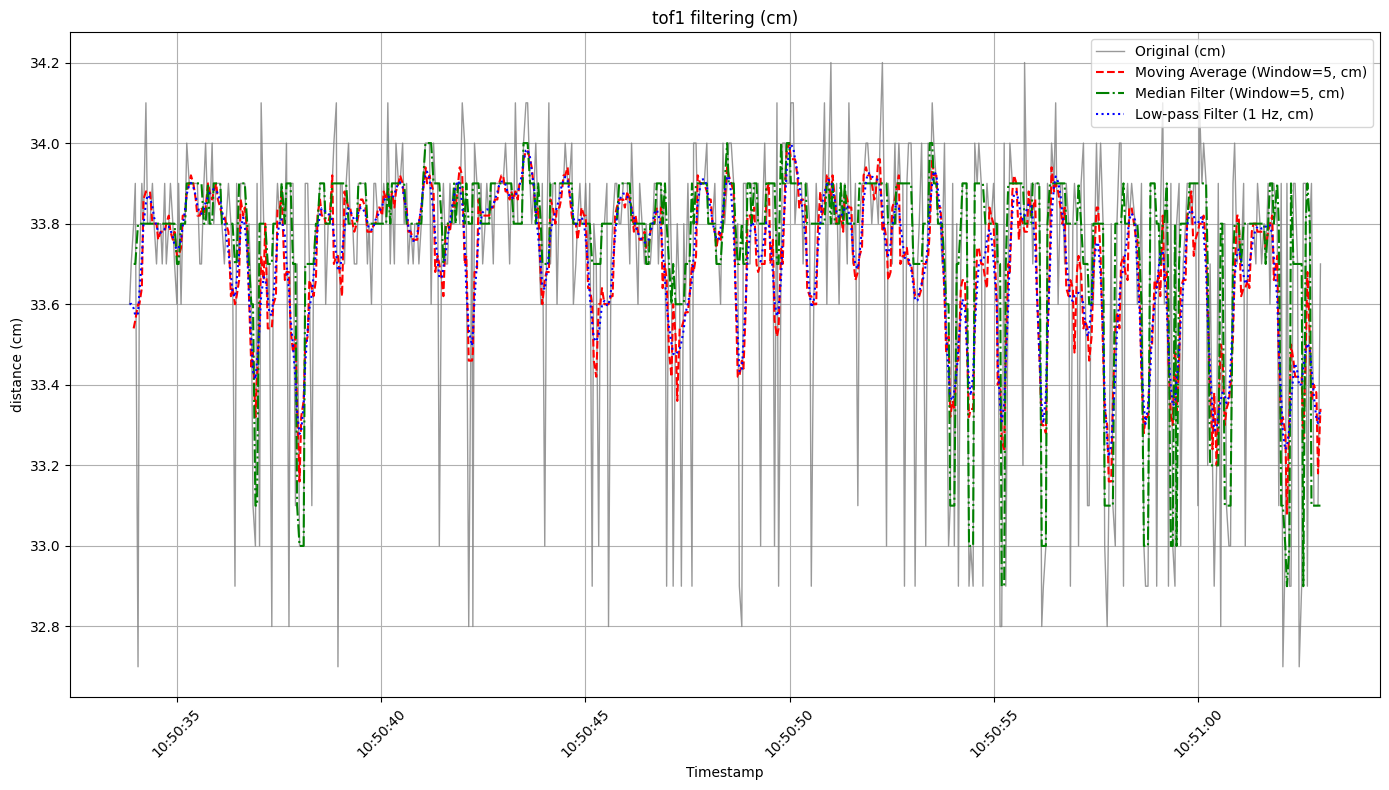

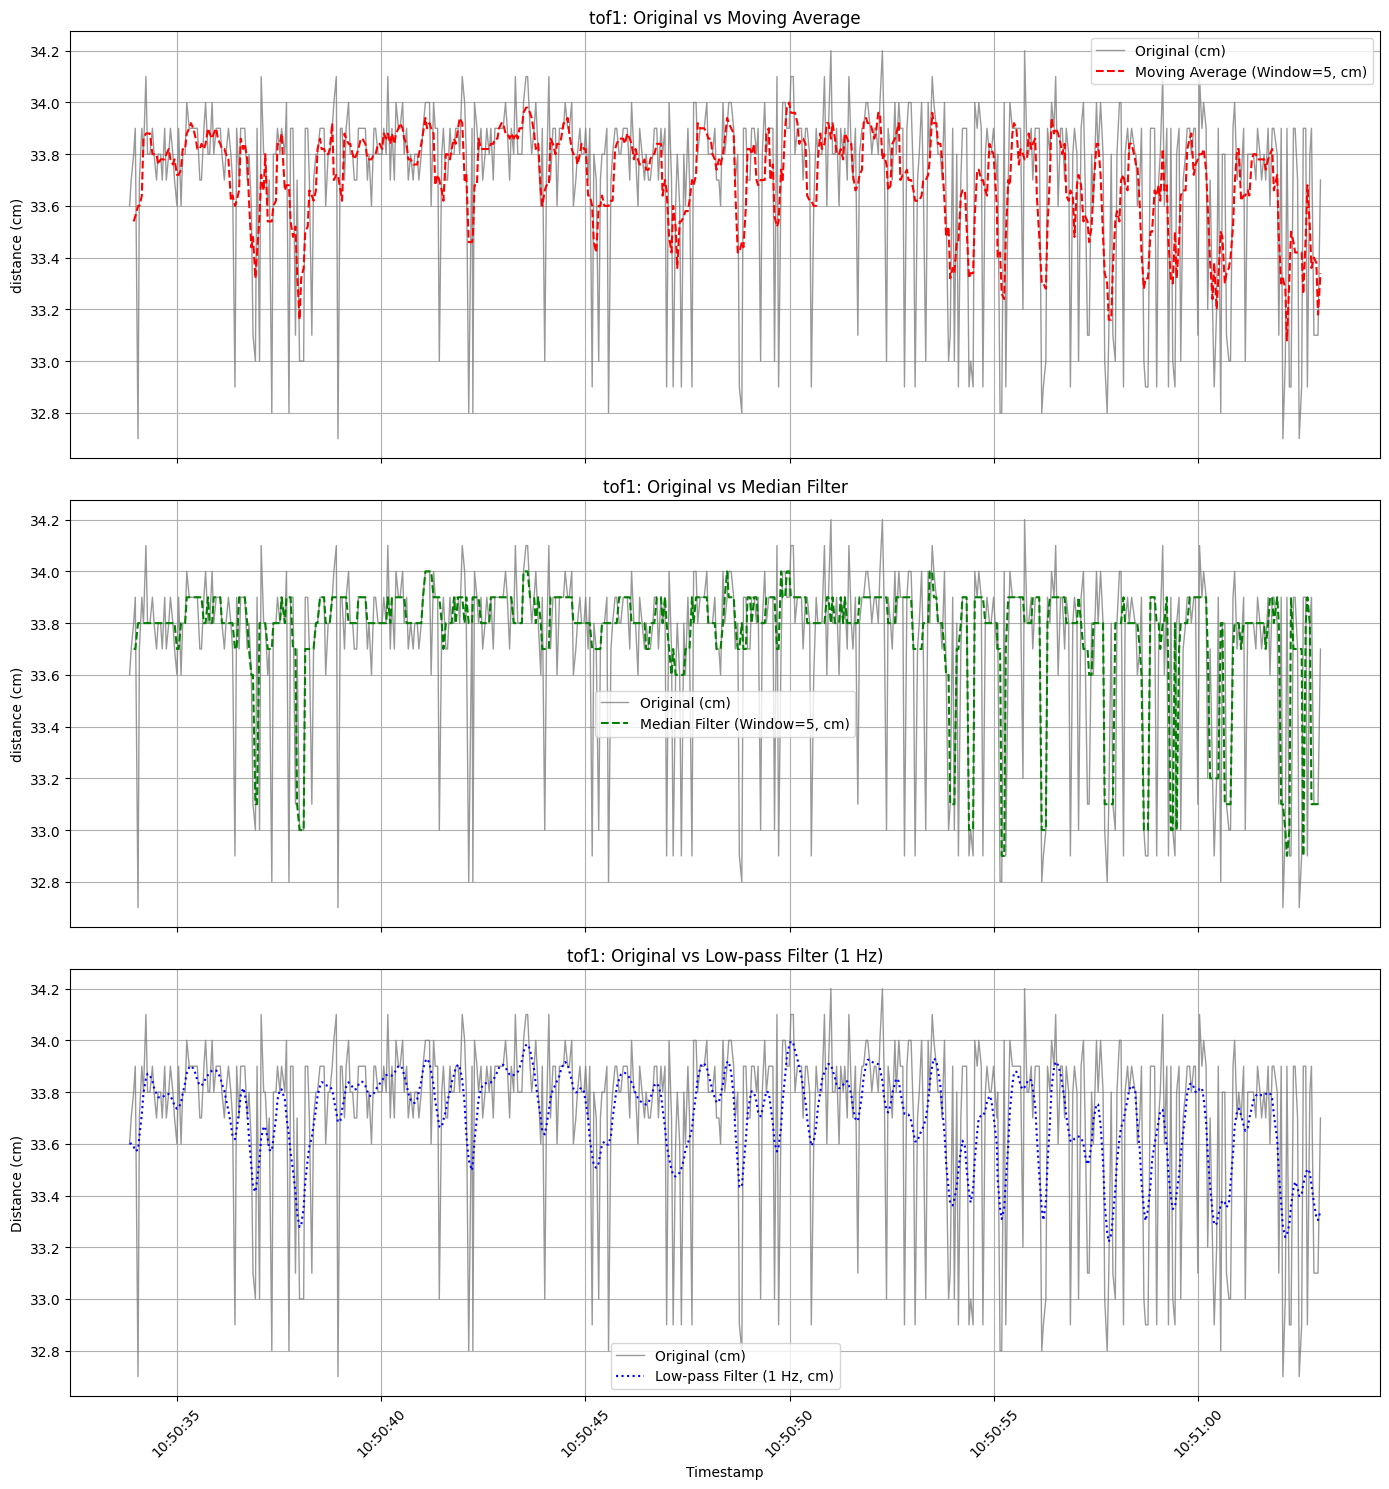

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal # นำเข้าไลบรารีนี้สำหรับการทำฟิลเตอร์ Low-pass

# อ่านไฟล์ CSV
df = pd.read_csv("../data/transparent_tof_30.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])

# กำหนดคอลัมน์ที่จะใช้ฟิลเตอร์และปัจจัยการแปลงหน่วย
tof_col = 'tof1'
conversion_factor = 0.1 # 1 mm = 0.1 cm

df_filtered = df.copy()

# แปลงข้อมูลต้นฉบับเป็นหน่วยเซนติเมตร
df_filtered[f'{tof_col}_cm'] = df_filtered[tof_col] * conversion_factor

# --- ใช้ฟิลเตอร์ต่างๆ ---
df_filtered[f'{tof_col}_MA_w5_cm'] = df_filtered[f'{tof_col}_cm'].rolling(window=5, center=True).mean()
df_filtered[f'{tof_col}_Median_w5_cm'] = df_filtered[f'{tof_col}_cm'].rolling(window=5, center=True).median()

# --- Low-pass filter (Butterworth) ---
# *** สำคัญ: ต้องแน่ใจว่าค่า sampling_rate นี้ถูกต้องตามข้อมูลของคุณ ***
# นี่คือค่าที่ใช้ในการออกแบบฟิลเตอร์ หากไม่ตรงกับข้อมูลจริง ผลลัพธ์อาจไม่เป็นไปตามคาด
sampling_rate = 10.0 # Hz (สมมติว่าข้อมูลของคุณมี 10 จุดต่อวินาที หรือความละเอียด 0.1 วินาที)
cutoff_frequency = 1.0 # Hz (ความถี่คัตออฟที่ 1 Hz)

nyquist_frequency = 0.5 * sampling_rate
normalized_cutoff_frequency = cutoff_frequency / nyquist_frequency

# ออกแบบฟิลเตอร์ Butterworth (อันดับ 2)
order = 2 # Order ของฟิลเตอร์
b, a = scipy.signal.butter(order, normalized_cutoff_frequency, btype='low', analog=False)

# ใช้ฟิลเตอร์กับข้อมูล
# filtfilt ใช้เพื่อป้องกัน phase shift
df_filtered[f'{tof_col}_LowPass_1Hz_cm'] = scipy.signal.filtfilt(b, a, df_filtered[f'{tof_col}_cm'])

# --- เลือกช่วงเวลาที่แคบลงเพื่อแสดงผล ---
# เลือกช่วงเวลาที่น่าสนใจ เช่น 10 วินาทีแรก หรือช่วงที่มีการเปลี่ยนแปลง
# คุณอาจต้องปรับ 'start_time' และ 'end_time' ตามข้อมูลของคุณ
# ตัวอย่าง: เลือกช่วง 10 วินาทีแรก
# start_time = df_filtered['timestamp'].min()
# end_time = start_time + pd.Timedelta(seconds=10)

# หรือเลือกช่วงเวลาเฉพาะเจาะจงที่สังเกตเห็นจากกราฟ เช่น 10:50:45 ถึง 10:50:55
start_time = pd.to_datetime('2025-07-23 10:50:33') # ปรับวันที่ให้ตรงกับข้อมูลจริงของคุณ
end_time = pd.to_datetime('2025-07-23 10:51:03') # ปรับวันที่ให้ตรงกับข้อมูลจริงของคุณ

df_plot = df_filtered[(df_filtered['timestamp'] >= start_time) & (df_filtered['timestamp'] <= end_time)]

# --- พล็อตผลลัพธ์ ---
plt.figure(figsize=(14, 8)) # ปรับขนาดกราฟให้เหมาะสม

# พล็อตข้อมูลต้นฉบับ (ลด alpha เพื่อให้มองเห็นเส้นฟิลเตอร์ได้ง่ายขึ้น)
plt.plot(df_plot['timestamp'], df_plot[f'{tof_col}_cm'], label='Original (cm)', color='gray', alpha=0.8, linewidth=1)

# พล็อตข้อมูลที่ผ่านฟิลเตอร์ Moving Average (เพิ่ม linewidth)
plt.plot(df_plot['timestamp'], df_plot[f'{tof_col}_MA_w5_cm'], label='Moving Average (Window=5, cm)', linestyle='--', color='red', linewidth=1.5)

# พล็อตข้อมูลที่ผ่านฟิลเตอร์ Median (เพิ่ม linewidth)
plt.plot(df_plot['timestamp'], df_plot[f'{tof_col}_Median_w5_cm'], label='Median Filter (Window=5, cm)', linestyle='-.', color='green', linewidth=1.5)

# พล็อตข้อมูลที่ผ่านฟิลเตอร์ Exponential Weighted Moving Average (เพิ่ม linewidth)
plt.plot(df_plot['timestamp'], df_plot[f'{tof_col}_LowPass_1Hz_cm'], label='Low-pass Filter (1 Hz, cm)', linestyle=':', color='blue', linewidth=1.5)

plt.title(f'{tof_col} filtering (cm)')
plt.xlabel('Timestamp')
plt.ylabel('distance (cm)')
plt.legend()
plt.grid(True)
plt.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# --- ตัวอย่างการพล็อตแบบ Subplots (หากต้องการเปรียบเทียบทีละคู่) ---
fig, axes = plt.subplots(3, 1, figsize=(14, 15), sharex=True) # 3 แถว, 1 คอลัมน์, แชร์แกน x

# กราฟที่ 1: Original vs Moving Average
axes[0].plot(df_plot['timestamp'], df_plot[f'{tof_col}_cm'], label='Original (cm)', color='gray', alpha=0.8, linewidth=1)
axes[0].plot(df_plot['timestamp'], df_plot[f'{tof_col}_MA_w5_cm'], label='Moving Average (Window=5, cm)', linestyle='--', color='red', linewidth=1.5)
axes[0].set_title(f'{tof_col}: Original vs Moving Average')
axes[0].set_ylabel('distance (cm)')
axes[0].legend()
axes[0].grid(True)

# กราฟที่ 2: Original vs Median Filter
axes[1].plot(df_plot['timestamp'], df_plot[f'{tof_col}_cm'], label='Original (cm)', color='gray', alpha=0.8, linewidth=1)
axes[1].plot(df_plot['timestamp'], df_plot[f'{tof_col}_Median_w5_cm'], label='Median Filter (Window=5, cm)', linestyle='--', color='green', linewidth=1.5)
axes[1].set_title(f'{tof_col}: Original vs Median Filter')
axes[1].set_ylabel('distance (cm)')
axes[1].legend()
axes[1].grid(True)

# กราฟที่ 3: Original vs Low-pass filter
axes[2].plot(df_plot['timestamp'], df_plot[f'{tof_col}_cm'], label='Original (cm)', color='gray', alpha=0.8, linewidth=1)
axes[2].plot(df_plot['timestamp'], df_plot[f'{tof_col}_LowPass_1Hz_cm'], label='Low-pass Filter (1 Hz, cm)', linestyle=':', color='blue', linewidth=1.5)
axes[2].set_title(f'{tof_col}: Original vs Low-pass Filter (1 Hz)')
axes[2].set_xlabel('Timestamp')
axes[2].set_ylabel('Distance (cm)')
axes[2].legend()
axes[2].grid(True)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

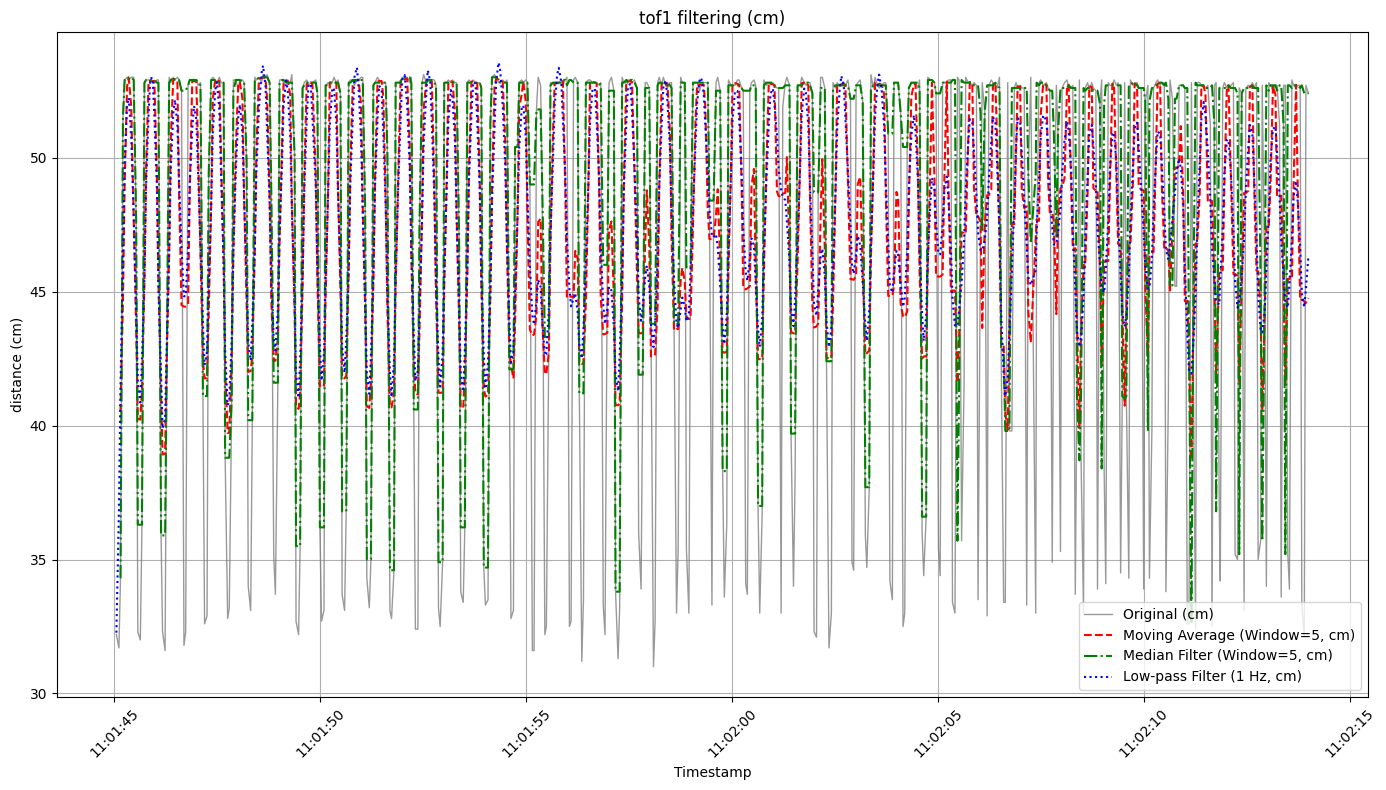

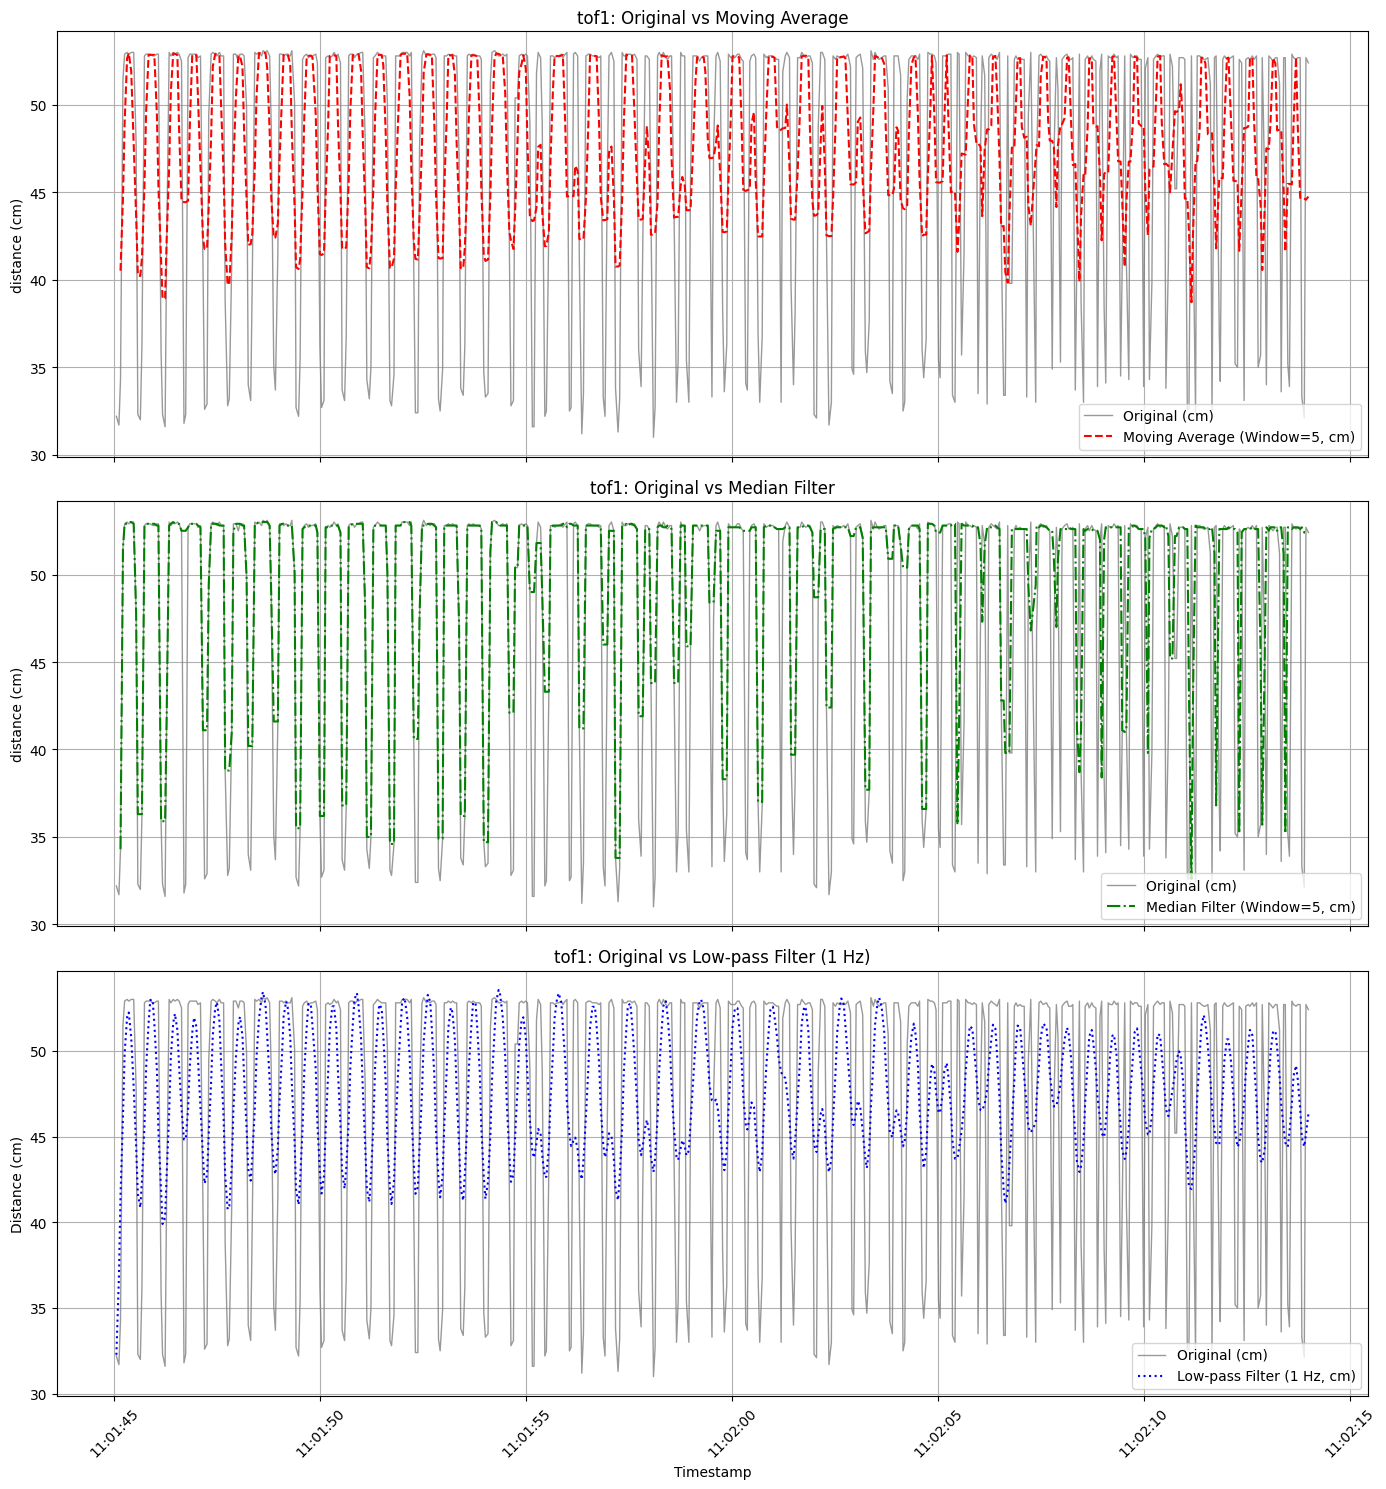

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal # นำเข้าไลบรารีนี้สำหรับการทำฟิลเตอร์ Low-pass

# อ่านไฟล์ CSV
df = pd.read_csv("../data/fast_motion_tof.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])

# กำหนดคอลัมน์ที่จะใช้ฟิลเตอร์และปัจจัยการแปลงหน่วย
tof_col = 'tof1'
conversion_factor = 0.1 # 1 mm = 0.1 cm

df_filtered = df.copy()

# แปลงข้อมูลต้นฉบับเป็นหน่วยเซนติเมตร
df_filtered[f'{tof_col}_cm'] = df_filtered[tof_col] * conversion_factor

# --- ใช้ฟิลเตอร์ต่างๆ ---
df_filtered[f'{tof_col}_MA_w5_cm'] = df_filtered[f'{tof_col}_cm'].rolling(window=5, center=True).mean()
df_filtered[f'{tof_col}_Median_w5_cm'] = df_filtered[f'{tof_col}_cm'].rolling(window=5, center=True).median()
df_filtered[f'{tof_col}_Median_w5_cm'] = df_filtered[f'{tof_col}_cm'].rolling(window=5, center=True).median()

# --- Low-pass filter (Butterworth) ---
# *** สำคัญ: ต้องแน่ใจว่าค่า sampling_rate นี้ถูกต้องตามข้อมูลของคุณ ***
# นี่คือค่าที่ใช้ในการออกแบบฟิลเตอร์ หากไม่ตรงกับข้อมูลจริง ผลลัพธ์อาจไม่เป็นไปตามคาด
sampling_rate = 10.0 # Hz (สมมติว่าข้อมูลของคุณมี 10 จุดต่อวินาที หรือความละเอียด 0.1 วินาที)
cutoff_frequency = 1.0 # Hz (ความถี่คัตออฟที่ 1 Hz)

nyquist_frequency = 0.5 * sampling_rate
normalized_cutoff_frequency = cutoff_frequency / nyquist_frequency

# ออกแบบฟิลเตอร์ Butterworth (อันดับ 2)
order = 2 # Order ของฟิลเตอร์
b, a = scipy.signal.butter(order, normalized_cutoff_frequency, btype='low', analog=False)

# ใช้ฟิลเตอร์กับข้อมูล
# filtfilt ใช้เพื่อป้องกัน phase shift
df_filtered[f'{tof_col}_LowPass_1Hz_cm'] = scipy.signal.filtfilt(b, a, df_filtered[f'{tof_col}_cm'])

# --- เลือกช่วงเวลาที่แคบลงเพื่อแสดงผล ---
# เลือกช่วงเวลาที่น่าสนใจ เช่น 10 วินาทีแรก หรือช่วงที่มีการเปลี่ยนแปลง
# คุณอาจต้องปรับ 'start_time' และ 'end_time' ตามข้อมูลของคุณ
# ตัวอย่าง: เลือกช่วง 10 วินาทีแรก
# start_time = df_filtered['timestamp'].min()
# end_time = start_time + pd.Timedelta(seconds=10)

# หรือเลือกช่วงเวลาเฉพาะเจาะจงที่สังเกตเห็นจากกราฟ เช่น 10:50:45 ถึง 10:50:55
start_time = pd.to_datetime('2025-07-23 11:01:45') # ปรับวันที่ให้ตรงกับข้อมูลจริงของคุณ
end_time = pd.to_datetime('2025-07-23 11:02:14') # ปรับวันที่ให้ตรงกับข้อมูลจริงของคุณ

df_plot = df_filtered[(df_filtered['timestamp'] >= start_time) & (df_filtered['timestamp'] <= end_time)]

# --- พล็อตผลลัพธ์ ---
plt.figure(figsize=(14, 8)) # ปรับขนาดกราฟให้เหมาะสม

# พล็อตข้อมูลต้นฉบับ (ลด alpha เพื่อให้มองเห็นเส้นฟิลเตอร์ได้ง่ายขึ้น)
plt.plot(df_plot['timestamp'], df_plot[f'{tof_col}_cm'], label='Original (cm)', color='gray', alpha=0.8, linewidth=1)

# พล็อตข้อมูลที่ผ่านฟิลเตอร์ Moving Average (เพิ่ม linewidth)
plt.plot(df_plot['timestamp'], df_plot[f'{tof_col}_MA_w5_cm'], label='Moving Average (Window=5, cm)', linestyle='--', color='red', linewidth=1.5)

# พล็อตข้อมูลที่ผ่านฟิลเตอร์ Median (เพิ่ม linewidth)
plt.plot(df_plot['timestamp'], df_plot[f'{tof_col}_Median_w5_cm'], label='Median Filter (Window=5, cm)', linestyle='-.', color='green', linewidth=1.5)

# พล็อตข้อมูลที่ผ่านฟิลเตอร์ Exponential Weighted Moving Average (เพิ่ม linewidth)
plt.plot(df_plot['timestamp'], df_plot[f'{tof_col}_LowPass_1Hz_cm'], label='Low-pass Filter (1 Hz, cm)', linestyle=':', color='blue', linewidth=1.5)


plt.title(f'{tof_col} filtering (cm)')
plt.xlabel('Timestamp')
plt.ylabel('distance (cm)')
plt.legend()
plt.grid(True)
plt.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# --- ตัวอย่างการพล็อตแบบ Subplots (หากต้องการเปรียบเทียบทีละคู่) ---
fig, axes = plt.subplots(3, 1, figsize=(14, 15), sharex=True) # 3 แถว, 1 คอลัมน์, แชร์แกน x

# กราฟที่ 1: Original vs Moving Average
axes[0].plot(df_plot['timestamp'], df_plot[f'{tof_col}_cm'], label='Original (cm)', color='gray', alpha=0.8, linewidth=1)
axes[0].plot(df_plot['timestamp'], df_plot[f'{tof_col}_MA_w5_cm'], label='Moving Average (Window=5, cm)', linestyle='--', color='red', linewidth=1.5)
axes[0].set_title(f'{tof_col}: Original vs Moving Average')
axes[0].set_ylabel('distance (cm)')
axes[0].legend()
axes[0].grid(True)

# กราฟที่ 2: Original vs Median Filter
axes[1].plot(df_plot['timestamp'], df_plot[f'{tof_col}_cm'], label='Original (cm)', color='gray', alpha=0.8, linewidth=1)
axes[1].plot(df_plot['timestamp'], df_plot[f'{tof_col}_Median_w5_cm'], label='Median Filter (Window=5, cm)', linestyle='-.', color='green', linewidth=1.5)
axes[1].set_title(f'{tof_col}: Original vs Median Filter')
axes[1].set_ylabel('distance (cm)')
axes[1].legend()
axes[1].grid(True)

# กราฟที่ 3: Original vs Low-pass filter
axes[2].plot(df_plot['timestamp'], df_plot[f'{tof_col}_cm'], label='Original (cm)', color='gray', alpha=0.8, linewidth=1)
axes[2].plot(df_plot['timestamp'], df_plot[f'{tof_col}_LowPass_1Hz_cm'], label='Low-pass Filter (1 Hz, cm)', linestyle=':', color='blue', linewidth=1.5)
axes[2].set_title(f'{tof_col}: Original vs Low-pass Filter (1 Hz)')
axes[2].set_xlabel('Timestamp')
axes[2].set_ylabel('Distance (cm)')
axes[2].legend()
axes[2].grid(True)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()